In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
df = pd.read_csv(r'C:\Users\hp\Downloads\train(1)(train(1)).csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [4]:
df.drop(['id' , 'date'] , axis = 1 , inplace = True)

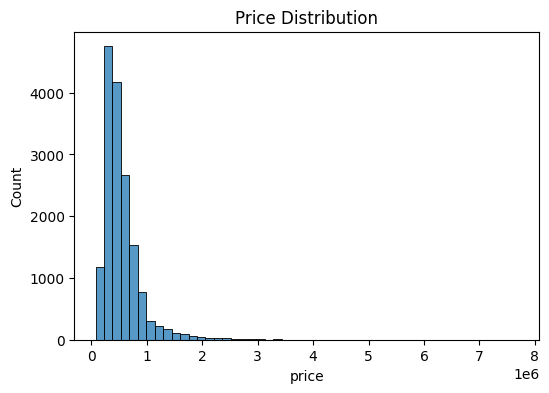

In [5]:
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=50)
plt.title("Price Distribution")
plt.show()

In [6]:
corr = df.corr(numeric_only=True)["price"].sort_values(ascending=False)
corr

price            1.000000
sqft_living      0.700933
grade            0.664266
sqft_above       0.602648
sqft_living15    0.581781
bathrooms        0.525487
view             0.390534
sqft_basement    0.320301
lat              0.310008
bedrooms         0.304454
floors           0.251428
waterfront       0.245221
yr_renovated     0.133075
sqft_lot         0.088526
sqft_lot15       0.076060
yr_built         0.048307
condition        0.031333
long             0.024279
zipcode         -0.054517
Name: price, dtype: float64

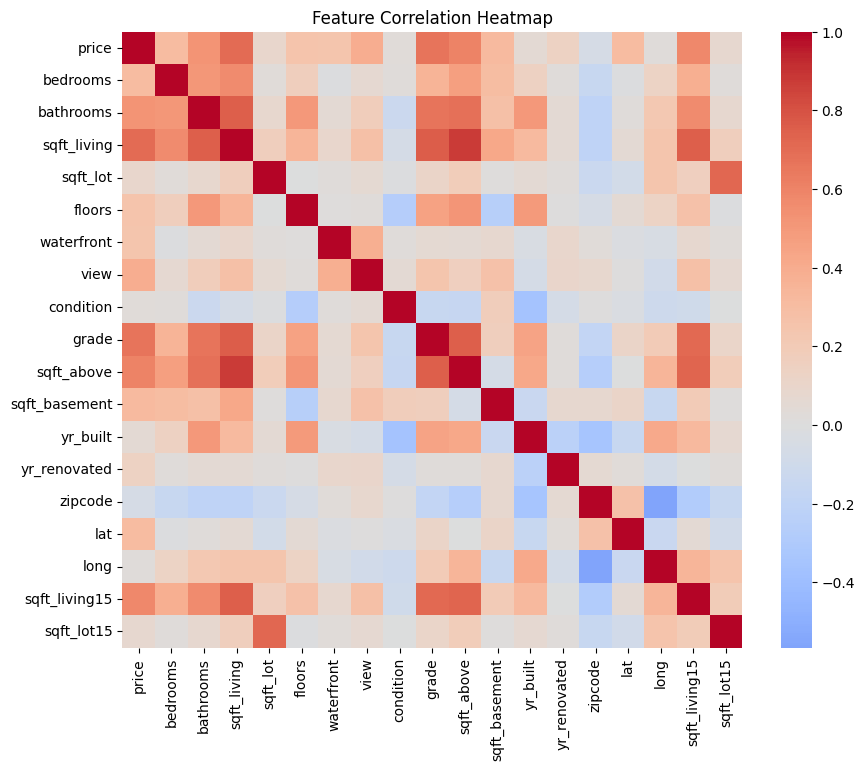

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()
#from here we can see the redundancy in features 

In [8]:
#i should remove sqft above and below 
df["basement_ratio"] = df["sqft_basement"] / (df["sqft_living"] + 1)
df.drop(columns=["sqft_above", "sqft_basement"], inplace=True)

In [9]:
df["living_vs_neighbors"] = df["sqft_living"] / (df["sqft_living15"] + 1)
df["lot_vs_neighbors"] = df["sqft_lot"] / (df["sqft_lot15"] + 1)
df["is_renovated"] = (df["yr_renovated"] > 0).astype(int)
df.drop(columns=["yr_renovated"], inplace=True)

In [10]:
df["has_view"] = (df["view"] > 0).astype(int)

In [11]:
df["log_price"] = np.log1p(df["price"])
df["sqft_living"]=np.log1p(df['sqft_living'])

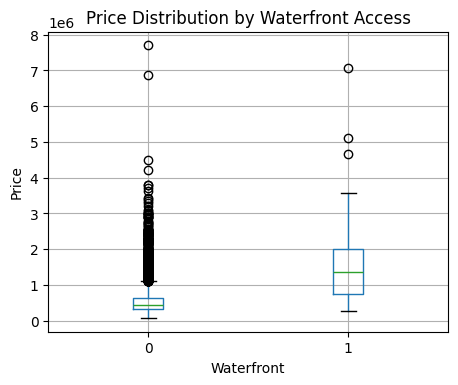

In [28]:
df.boxplot(column="price", by="waterfront", figsize=(5,4))
plt.title("Price Distribution by Waterfront Access")
plt.suptitle("")
plt.xlabel("Waterfront")
plt.ylabel("Price")
plt.show()


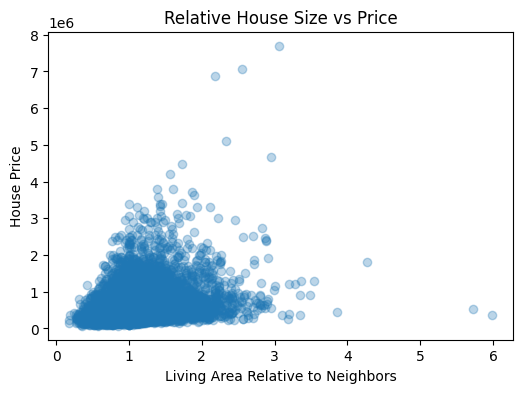

In [27]:
plt.figure(figsize=(6,4))
plt.scatter(df["living_vs_neighbors"], df["price"], alpha=0.3)
plt.xlabel("Living Area Relative to Neighbors")
plt.ylabel("House Price")
plt.title("Relative House Size vs Price")
plt.show()


In [12]:
FEATURES = [
    "sqft_living",
    "sqft_lot",
    "bedrooms", "bathrooms", "floors",
    "condition", "grade",
    "waterfront", "has_view",
    "living_vs_neighbors", "lot_vs_neighbors",
    "basement_ratio",
    "is_renovated"
]

X = df[FEATURES]
y = df["log_price"]

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=45
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test , y_pred)
rmse , r2

(np.float64(0.3328985763880459), 0.596403553780113)

In [16]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred = ridge.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test , y_pred)
rmse_ridge, r2

(np.float64(0.3328988421812694), 0.5964029093000768)

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test , y_pred)
rmse_rf, r2

(np.float64(0.2996229923999627), 0.6730557289018727)

In [18]:
importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance


grade                  0.418380
sqft_living            0.241921
sqft_lot               0.085468
living_vs_neighbors    0.068612
lot_vs_neighbors       0.047451
basement_ratio         0.033199
condition              0.023213
bathrooms              0.021737
floors                 0.016047
has_view               0.015655
bedrooms               0.011949
waterfront             0.008513
is_renovated           0.007854
dtype: float64

In [19]:
# using XGBoost and LightGBM
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)


In [20]:
xgb_model.fit(
    X_train, y_train,
    verbose=False
)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [21]:
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

rmse_xgb, r2_xgb


(np.float64(0.29379270877208313), 0.685655776139497)

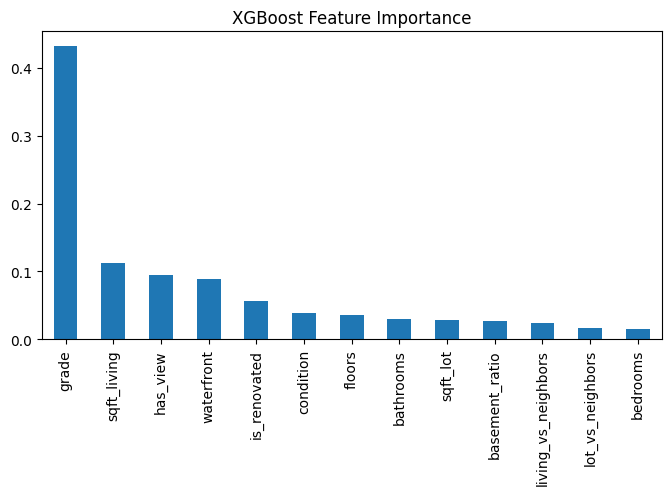

In [22]:
import matplotlib.pyplot as plt

xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

xgb_importance.plot(kind="bar", figsize=(8,4))
plt.title("XGBoost Feature Importance")
plt.show()


In [23]:
from lightgbm import LGBMRegressor
lgb_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [24]:
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

rmse_lgb, r2_lgb


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1341
[LightGBM] [Info] Number of data points in the train set: 12967, number of used features: 13
[LightGBM] [Info] Start training from score 13.047260


(np.float64(0.2942562177652793), 0.6846631285688174)